# 3D simulation and fitting

This tutorial shows how to do a 3D map-based simulation and fit.

For a tutorial on how to do a 3D map analyse of existing data, see the `analysis_3d` tutorial.

This can be useful to do a performance / sensitivity study, or to evaluate the capabilities of Gammapy or a given analysis method. Note that is is a binned simulation as is e.g. done also in Sherpa for Chandra, not an event sampling and anbinned analysis as is done e.g. in the Fermi ST or ctools.

## Imports and versions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from gammapy.irf import (
    EffectiveAreaTable2D,
    EnergyDispersion2D,
    EnergyDependentMultiGaussPSF,
    Background3D,
)
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap, Map
from gammapy.spectrum.models import PowerLaw
from gammapy.image.models import SkyGaussian
from gammapy.cube.models import SkyModel, SkyModels
from gammapy.cube import MapFit, MapEvaluator, PSFKernel
from gammapy.cube import make_map_exposure_true_energy, make_map_background_irf

In [3]:
!gammapy info --no-envvar --no-dependencies --no-system


Gammapy package:

	path                   : /home/hfm/adonath/github/adonath/gammapy/gammapy 
	version                : 0.8.dev7296 
	githash                : 2b363a5f196b9055e99cd31ecd0dcde5dab217f9 



## Simulate

In [4]:
def get_irfs():
    """Load CTA IRFs"""
    filename = "$GAMMAPY_EXTRA/datasets/cta-1dc/caldb/data/cta//1dc/bcf/South_z20_50h/irf_file.fits"
    psf = EnergyDependentMultiGaussPSF.read(
        filename, hdu="POINT SPREAD FUNCTION"
    )
    aeff = EffectiveAreaTable2D.read(filename, hdu="EFFECTIVE AREA")
    edisp = EnergyDispersion2D.read(filename, hdu="ENERGY DISPERSION")
    bkg = Background3D.read(filename, hdu="BACKGROUND")
    return dict(psf=psf, aeff=aeff, edisp=edisp, bkg=bkg)


irfs = get_irfs()

In [5]:
# Define sky model to simulate the data
spatial_model = SkyGaussian(lon_0="0.2 deg", lat_0="0.1 deg", sigma="0.3 deg")
spectral_model = PowerLaw(
    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model
)
print(sky_model)

SkyModel

spatial_model = SkyGaussian

Parameters: 

	 name   value   error unit min max
	----- --------- ----- ---- --- ---
	lon_0 2.000e-01   nan  deg nan nan
	lat_0 1.000e-01   nan  deg nan nan
	sigma 3.000e-01   nan  deg nan nan

spectral_model = PowerLaw

Parameters: 

	   name     value   error       unit         min    max
	--------- --------- ----- --------------- --------- ---
	    index 3.000e+00   nan                       nan nan
	amplitude 1.000e-11   nan 1 / (cm2 s TeV)       nan nan
	reference 1.000e+00   nan             TeV 0.000e+00 nan



In [6]:
# Define map geometry
axis = MapAxis.from_edges(
    np.logspace(-1., 1., 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0), binsz=0.02, width=(5, 4), coordsys="GAL", axes=[axis]
)

In [7]:
# Define some observation parameters
# Here we just have a single observation,
# we are not simulating many pointings / observations
pointing = SkyCoord(1, 0.5, unit="deg", frame="galactic")
livetime = 1 * u.hour
offset_max = 2 * u.deg
offset = Angle("2 deg")

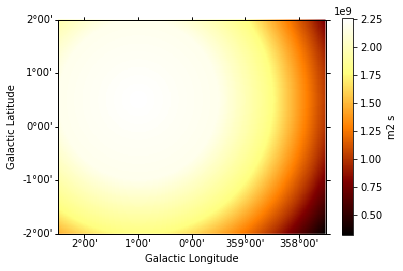

In [8]:
exposure = make_map_exposure_true_energy(
    pointing=pointing, livetime=livetime, aeff=irfs["aeff"], geom=geom
)
exposure.slice_by_idx({"energy": 3}).plot(add_cbar=True);

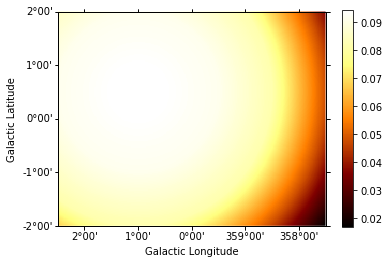

In [9]:
background = make_map_background_irf(
    pointing=pointing, livetime=livetime, bkg=irfs["bkg"], geom=geom
)
background.slice_by_idx({"energy": 3}).plot(add_cbar=True);

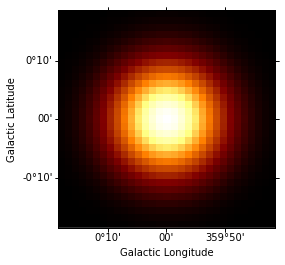

In [10]:
psf = irfs["psf"].to_energy_dependent_table_psf(theta=offset)
psf_kernel = PSFKernel.from_table_psf(psf, geom, max_radius=0.3 * u.deg)
psf_kernel.psf_kernel_map.sum_over_axes().plot(stretch="log");

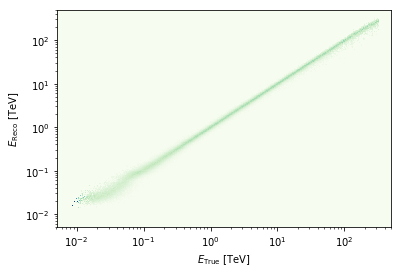

In [11]:
edisp = irfs["edisp"].to_energy_dispersion(offset=offset)
edisp.plot_matrix();

In [12]:
%%time
# The idea is that we have this class that can compute `npred`
# maps, i.e. "predicted counts per pixel" given the model and
# the observation infos: exposure, background, PSF and EDISP
evaluator = MapEvaluator(
    model=sky_model, exposure=exposure, background=background, psf=psf_kernel
)

CPU times: user 15 µs, sys: 1e+03 ns, total: 16 µs
Wall time: 21.2 µs


In [13]:
# Accessing and saving a lot of the following maps is for debugging.
# Just for a simulation one doesn't need to store all these things.
# dnde = evaluator.compute_dnde()
# flux = evaluator.compute_flux()
npred = evaluator.compute_npred()
npred_map = WcsNDMap(geom, npred)

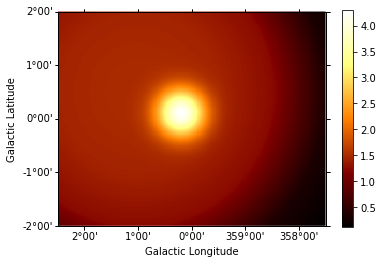

In [14]:
npred_map.sum_over_axes().plot(add_cbar=True);

In [15]:
# This one line is the core of how to simulate data when
# using binned simulation / analysis: you Poisson fluctuate
# npred to obtain simulated observed counts.
# Compute counts as a Poisson fluctuation
rng = np.random.RandomState(seed=42)
counts = rng.poisson(npred)
counts_map = WcsNDMap(geom, counts)

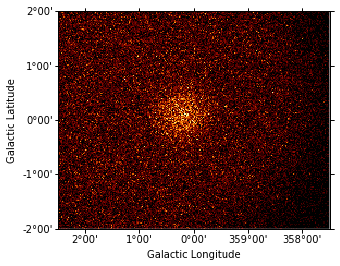

In [16]:
counts_map.sum_over_axes().plot();

## Fit

Now let's analyse the simulated data.
Here we just fit it again with the same model we had before, but you could do any analysis you like here, e.g. fit a different model, or do a region-based analysis, ...

In [17]:
# Define sky model to fit the data
spatial_model = SkyGaussian(lon_0="0 deg", lat_0="0 deg", sigma="1 deg")
spectral_model = PowerLaw(
    index=2, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)
print(model)

SkyModel

spatial_model = SkyGaussian

Parameters: 

	 name   value   error unit min max
	----- --------- ----- ---- --- ---
	lon_0 0.000e+00   nan  deg nan nan
	lat_0 0.000e+00   nan  deg nan nan
	sigma 1.000e+00   nan  deg nan nan

spectral_model = PowerLaw

Parameters: 

	   name     value   error       unit         min    max
	--------- --------- ----- --------------- --------- ---
	    index 2.000e+00   nan                       nan nan
	amplitude 1.000e-11   nan 1 / (cm2 s TeV)       nan nan
	reference 1.000e+00   nan             TeV 0.000e+00 nan



In [18]:
%%time
fit = MapFit(
    model=model,
    counts=counts_map,
    exposure=exposure,
    background=background,
    psf=psf_kernel,
)

result = fit.run(optimize_opts={"print_level": 1})

FCN = 268093.5232037166 
 TOTAL NCALL = 336 
 NCALLS = 336 
 
 
 EDM = 9.670011191821828e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,par_000_lon_0,0.209774,0.00854379,0,0,,,
2,par_001_lat_0,0.095239,0.00859709,0,0,,,
3,par_002_sigma,-0.290008,0.00592294,0,0,,,
4,par_003_index,2.99218,0.029204,0,0,,,
5,par_004_amplitude,1.01264,0.0495146,0,0,,,
6,par_005_reference,1,1,0,0,0.0,,FIXED


CPU times: user 18.5 s, sys: 42.6 ms, total: 18.5 s
Wall time: 18.5 s


True model:

In [19]:
print(sky_model)

SkyModel

spatial_model = SkyGaussian

Parameters: 

	 name   value   error unit min max
	----- --------- ----- ---- --- ---
	lon_0 2.000e-01   nan  deg nan nan
	lat_0 1.000e-01   nan  deg nan nan
	sigma 3.000e-01   nan  deg nan nan

spectral_model = PowerLaw

Parameters: 

	   name     value   error       unit         min    max
	--------- --------- ----- --------------- --------- ---
	    index 3.000e+00   nan                       nan nan
	amplitude 1.000e-11   nan 1 / (cm2 s TeV)       nan nan
	reference 1.000e+00   nan             TeV 0.000e+00 nan



Best-fit model:

In [20]:
print(result.model)

SkyModel

spatial_model = SkyGaussian

Parameters: 

	 name   value    error unit min max
	----- ---------- ----- ---- --- ---
	lon_0  2.098e-01   nan  deg nan nan
	lat_0  9.524e-02   nan  deg nan nan
	sigma -2.900e-01   nan  deg nan nan

spectral_model = PowerLaw

Parameters: 

	   name     value   error       unit         min    max
	--------- --------- ----- --------------- --------- ---
	    index 2.992e+00   nan                       nan nan
	amplitude 1.013e-11   nan 1 / (cm2 s TeV)       nan nan
	reference 1.000e+00   nan             TeV 0.000e+00 nan



In [21]:
# TODO: show e.g. how to make a residual image

## iminuit

What we have done for now is to write a very thin wrapper for http://iminuit.readthedocs.io/
as a fitting backend. This is just a prototype, we will improve this interface and
add other fitting backends (e.g. Sherpa or scipy.optimize or emcee or ...)

As a power-user, you can access ``fit._iminuit`` and get the full power of what is developed there already.
E.g. the ``fit.fit()`` call ran ``Minuit.migrad()`` and ``Minuit.hesse()`` in the background, and you have
access to e.g. the covariance matrix, or can check a likelihood profile, or can run ``Minuit.minos()``
to compute asymmetric errors or ...

In [22]:
# Check correlation between model parameters
# As expected in this simple case,
# spatial parameters are uncorrelated,
# but the spectral model amplitude and index are correlated as always
fit.minuit.print_matrix()

+,par_000_lon_0,par_001_lat_0,par_002_sigma,par_003_index,par_004_amplitude
par_000_lon_0,1.00,-0.00,-0.02,-0.01,0.01
par_001_lat_0,-0.00,1.00,-0.01,0.01,-0.01
par_002_sigma,-0.02,-0.01,1.00,0.02,-0.31
par_003_index,-0.01,0.01,0.02,1.00,-0.83
par_004_amplitude,0.01,-0.01,-0.31,-0.83,1.00


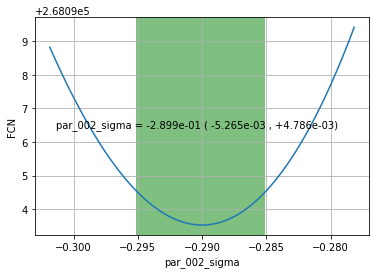

In [23]:
# You can use likelihood profiles to check if your model is
# well constrained or not, and if the fit really converged
fit.minuit.draw_profile("par_002_sigma");